# Model Test
Uses a pre-trained model to make predictions for dates that occur after the last date included in the training data.

In [96]:
%load_ext autoreload
%autoreload 2

In [97]:
import os
print(os.getcwd())

import sys
sys.path.append('..\\..')
print(sys.path)

import torch
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Device: {device}")


c:\Users\User\AAAMio\Projects\riga-stock-nn\src\notebooks\stock_up_down
['c:\\Users\\User\\anaconda3\\envs\\pytorch\\python312.zip', 'c:\\Users\\User\\anaconda3\\envs\\pytorch\\DLLs', 'c:\\Users\\User\\anaconda3\\envs\\pytorch\\Lib', 'c:\\Users\\User\\anaconda3\\envs\\pytorch', '', 'c:\\Users\\User\\anaconda3\\envs\\pytorch\\Lib\\site-packages', 'c:\\Users\\User\\anaconda3\\envs\\pytorch\\Lib\\site-packages\\win32', 'c:\\Users\\User\\anaconda3\\envs\\pytorch\\Lib\\site-packages\\win32\\lib', 'c:\\Users\\User\\anaconda3\\envs\\pytorch\\Lib\\site-packages\\Pythonwin', '..\\..', '..\\..', '..\\..', '..\\..']
Device: cuda


### SET PARAMETERS:

In [88]:
import utils.text_utils as tu

MODEL_NAME= f"2024-06-01-0656-TSLA-predictDOWN-dates20190102-20231229-days3-down300-up300-in16-hid12-pos_weight13979-prec9737pct-fp22tp815-high_prec.pth"

TICKER= tu.extract_company(MODEL_NAME)
DATA_INTERVAL_MINUTES = 15   # (Set to 5 or 15)
DATA_AFTER_HOURS = False

DAYS_PREDICT = tu.extract_days(MODEL_NAME)
DOWN_PCTS_PREDICT= tu.extract_pcts(MODEL_NAME, "down")
UP_PCTS_PREDICT= tu.extract_pcts(MODEL_NAME, "up")

PREDICT_UP = tu.is_predict_up(MODEL_NAME)
if PREDICT_UP:
    INDEX_KEEP= 2
    INDEX_REMOVE_A= 0
    INDEX_REMOVE_B= 1
else:
    INDEX_KEEP= 0
    INDEX_REMOVE_A= 1
    INDEX_REMOVE_B= 2

signal_avg= [
    2, 
    3, 
    5, 
    8, 
    13, 
    21, 
    34, 
    55, 
    89, 
    144, 
    233, 
    377, 
    610, 
    987, 
    1597, 
    2584]

HIDDEN_UNITS=12

TEST_THRESHOLD = 0.9598954



# Load training data (!!!ONLY TO VERIFY):
Use to verify results: compare with results obtain when training
If don't need to verify training data Skip to step that load test data

In [5]:
from datetime import datetime

import settings
import apis.tiingo_api as tiingo

secret_key= settings.get_secret("tiingo-key")

### TRAINING DATA
csv_data2019= tiingo.download_ticker(secret_key, TICKER, datetime(2019, 1, 1), datetime(2020,1,1), DATA_INTERVAL_MINUTES, DATA_AFTER_HOURS)
csv_data2020= tiingo.download_ticker(secret_key, TICKER, datetime(2020, 1, 1), datetime(2021,1,1), DATA_INTERVAL_MINUTES, DATA_AFTER_HOURS)
csv_data2021= tiingo.download_ticker(secret_key, TICKER, datetime(2021, 1, 1), datetime(2022,1,1), DATA_INTERVAL_MINUTES, DATA_AFTER_HOURS)
csv_data2022= tiingo.download_ticker(secret_key, TICKER, datetime(2022, 1, 1), datetime(2023,1,1), DATA_INTERVAL_MINUTES, DATA_AFTER_HOURS)
csv_data2023= tiingo.download_ticker(secret_key, TICKER, datetime(2023, 1, 1), datetime(2024,1,1), DATA_INTERVAL_MINUTES, DATA_AFTER_HOURS)
# csv_data2024= tiingo.download_ticker(secret_key, TICKER, datetime(2024, 1, 1), datetime(2024,2,1), DATA_INTERVAL_MINUTES, DATA_AFTER_HOURS)

Retrieving TSLA from 2019-01-01 00:00:00 to 2020-01-01 00:00:00 on 15m - https://api.tiingo.com/iex/TSLA/prices?token=55daa0bf5f29eb5b33b56c9f996afe5eb2dae346&startDate=2019-01-01&endDate=2020-01-01&resampleFreq=15min&afterHours=false&format=csv
Retrieving TSLA from 2020-01-01 00:00:00 to 2021-01-01 00:00:00 on 15m - https://api.tiingo.com/iex/TSLA/prices?token=55daa0bf5f29eb5b33b56c9f996afe5eb2dae346&startDate=2020-01-01&endDate=2021-01-01&resampleFreq=15min&afterHours=false&format=csv
Retrieving TSLA from 2021-01-01 00:00:00 to 2022-01-01 00:00:00 on 15m - https://api.tiingo.com/iex/TSLA/prices?token=55daa0bf5f29eb5b33b56c9f996afe5eb2dae346&startDate=2021-01-01&endDate=2022-01-01&resampleFreq=15min&afterHours=false&format=csv
Retrieving TSLA from 2022-01-01 00:00:00 to 2023-01-01 00:00:00 on 15m - https://api.tiingo.com/iex/TSLA/prices?token=55daa0bf5f29eb5b33b56c9f996afe5eb2dae346&startDate=2022-01-01&endDate=2023-01-01&resampleFreq=15min&afterHours=false&format=csv
Retrieving TSLA 

In [ ]:
import io
import pandas as pd

# ### TRAINING DATA
df2019 = pd.read_csv(io.StringIO(csv_data2019))
df2020 = pd.read_csv(io.StringIO(csv_data2020))
df2021 = pd.read_csv(io.StringIO(csv_data2021))
df2022 = pd.read_csv(io.StringIO(csv_data2022))
df2023 = pd.read_csv(io.StringIO(csv_data2023))
# df2024 = pd.read_csv(io.StringIO(csv_data2024))

if not df2019.empty:
    print("Concatenating from 2019")
    df = pd.concat([df2019, df2020, df2021, df2022, df2023], axis=0, ignore_index=True)
elif not df2020.empty:
    print("Concatenating from 2020")
    df = pd.concat([df2020, df2021, df2022, df2023], axis=0, ignore_index=True)
else:
    print("Concatenating from 2021")
    df = pd.concat([df2021, df2022, df2023], axis=0, ignore_index=True)

# if not df2024.empty:
#     print("Concatenating from 2024")
#     df = pd.concat([df, df2024], axis=0, ignore_index=True)

## LOADING TEST DATA

In [56]:
from datetime import datetime

import settings
import apis.tiingo_api as tiingo

secret_key= settings.get_secret("tiingo-key")

# # For first prediction need signal_avg[-1]=2584 ticks -> 2584 / 26 ~ 100 days -> 100 * 7 / 5 / 30 = 4.6 months
csv_data2023= tiingo.download_ticker(secret_key, TICKER, datetime(2023, 8, 1), datetime(2023,12,31), DATA_INTERVAL_MINUTES, DATA_AFTER_HOURS)
csv_data2024= tiingo.download_ticker(secret_key, TICKER, datetime(2024, 1, 1), datetime(2024,5,25), DATA_INTERVAL_MINUTES, DATA_AFTER_HOURS)


Retrieving TSLA from 2023-08-01 00:00:00 to 2023-12-31 00:00:00 on 15m - https://api.tiingo.com/iex/TSLA/prices?token=55daa0bf5f29eb5b33b56c9f996afe5eb2dae346&startDate=2023-08-01&endDate=2023-12-31&resampleFreq=15min&afterHours=false&format=csv
Retrieving TSLA from 2024-01-01 00:00:00 to 2024-05-25 00:00:00 on 15m - https://api.tiingo.com/iex/TSLA/prices?token=55daa0bf5f29eb5b33b56c9f996afe5eb2dae346&startDate=2024-01-01&endDate=2024-05-25&resampleFreq=15min&afterHours=false&format=csv


In [57]:
import io
import pandas as pd

### TEST PREDICTIONS ON RECENT DATA
df2023 = pd.read_csv(io.StringIO(csv_data2023))
df2024 = pd.read_csv(io.StringIO(csv_data2024))
df = pd.concat([df2023, df2024], axis=0, ignore_index=True)


In [58]:
# Validates that data has been concatenated correctly = ordered ascending
if df["date"].is_monotonic_increasing and df["date"].is_unique:
    print("Correct: DataFrame is in ascending order.")
else:
    print("Error: DataFrame is not in ascending order.")


Correct: DataFrame is in ascending order.


In [59]:
# Verify expected dates correspond with the data you intend to use
print(f"Test data first:\n{df[['date', 'close']][:5]}")
print(f"Test data last:\n{df[['date', 'close']][-5:]}")

Test data first:
                        date   close
0  2023-08-01 09:30:00-04:00  264.41
1  2023-08-01 09:45:00-04:00  262.89
2  2023-08-01 10:00:00-04:00  261.70
3  2023-08-01 10:15:00-04:00  262.56
4  2023-08-01 10:30:00-04:00  263.45
Test data last:
                           date    close
5533  2024-05-24 14:45:00-04:00  179.535
5534  2024-05-24 15:00:00-04:00  179.245
5535  2024-05-24 15:15:00-04:00  179.525
5536  2024-05-24 15:30:00-04:00  179.710
5537  2024-05-24 15:45:00-04:00  179.250


In [98]:

# If quotes every 15min there 26 per day if quotes every 5min there are 78 per day
TICKS_IN_DAY = 26 if DATA_INTERVAL_MINUTES == 15 else 78
# How many data ticks are inspecting to determine the if up or down by percentage 
TICKS_PREDICT= TICKS_IN_DAY * DAYS_PREDICT
REACH_PCT= 0.95

import classifiers.up_down_classifier as udc
import classifiers.ewa_classifier as ec

alpha= ec.calculate_ewa_alpha(TICKS_PREDICT, REACH_PCT)
print(f"alpha: {alpha:.4f} for window: {TICKS_PREDICT} and reach: {REACH_PCT}")

classes_calc = udc.UpsDownsClassifier(TICKS_PREDICT, DOWN_PCTS_PREDICT, UP_PCTS_PREDICT)

close_prices = df['close'].astype(float).tolist()
input_data= ec.calculate_ewas(close_prices, alpha)

classes= classes_calc.classify(input_data)
print(f"Check correct '-1' point (window={TICKS_PREDICT}): {classes[-TICKS_PREDICT-1:-TICKS_PREDICT+1]}")
print(f"prices vs input_data: {[(p, c) for p, c in zip(close_prices[2650:3000], input_data[2650:3000])]}")
print(f"input_data vs classes: {[(p, c) for p, c in zip(input_data[2650:3000], classes[2650:3000])]}")


alpha: 0.0377 for window: 78 and reach: 0.95
Check correct '-1' point (window=78): [1, nan]
prices vs input_data: [(249.255, 254.8453149997456), (247.21, 254.55762675886103), (252.99, 254.49856072365026), (249.81, 254.3219021592148), (250.15, 254.16471058383553), (249.64, 253.99422566888194), (250.62, 253.8670894541926), (251.05, 253.76094537113667), (252.18, 253.7013775088059), (252.97, 253.6738202031888), (253.0, 253.6484315782356), (252.36, 253.5998852361063), (251.155, 253.5077652996317), (251.27, 253.42344935947926), (251.61, 253.35512106442144), (250.795, 253.2586591993249), (251.03, 253.17468636459492), (251.255, 253.10235520428276), (251.7, 253.04951637552077), (252.81, 253.04049172562236), (252.825, 253.0323722917193), (252.96, 253.0296454026133), (253.71, 253.0552802346152), (253.275, 253.06355897528186), (253.835, 253.09262581945984), (254.575, 253.1484796539574), (253.835, 253.17434680294747), (254.535, 253.2256143570336), (257.56, 253.38892808816087), (256.22, 253.49559901

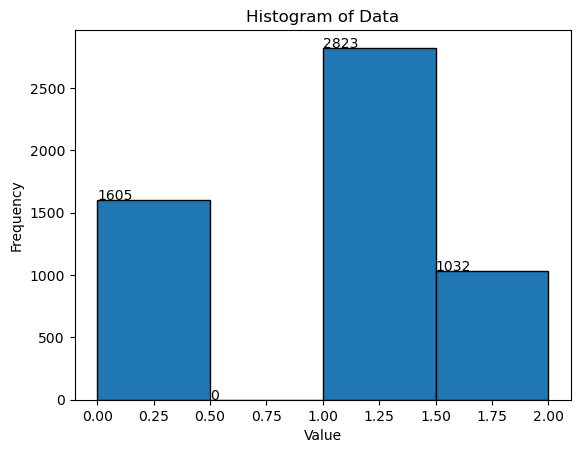

In [99]:
# Display histogram for the classes

import matplotlib.pyplot as plt

# Create a histogram
hist_values, bin_edges, _ = plt.hist(classes, bins=4, edgecolor='black')

plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Histogram of Data')

# Display frequency on top of each bar
for value, edge in zip(hist_values, bin_edges[:-1]):
    plt.text(float(edge), float(value), str(int(value)), color='black')
    
plt.show()

In [100]:
# Show percentages of each class value
import utils.list_utils as lu

lu.display_frequency_classes(classes, DOWN_PCTS_PREDICT, UP_PCTS_PREDICT)

Total: 5538
 28.98%   1605 times -3.0% change (0)
 50.98%   2823 times   0% change (1)
 18.63%   1032 times 3.0% change (2)
  1.41%     78 times   0% change (nan)


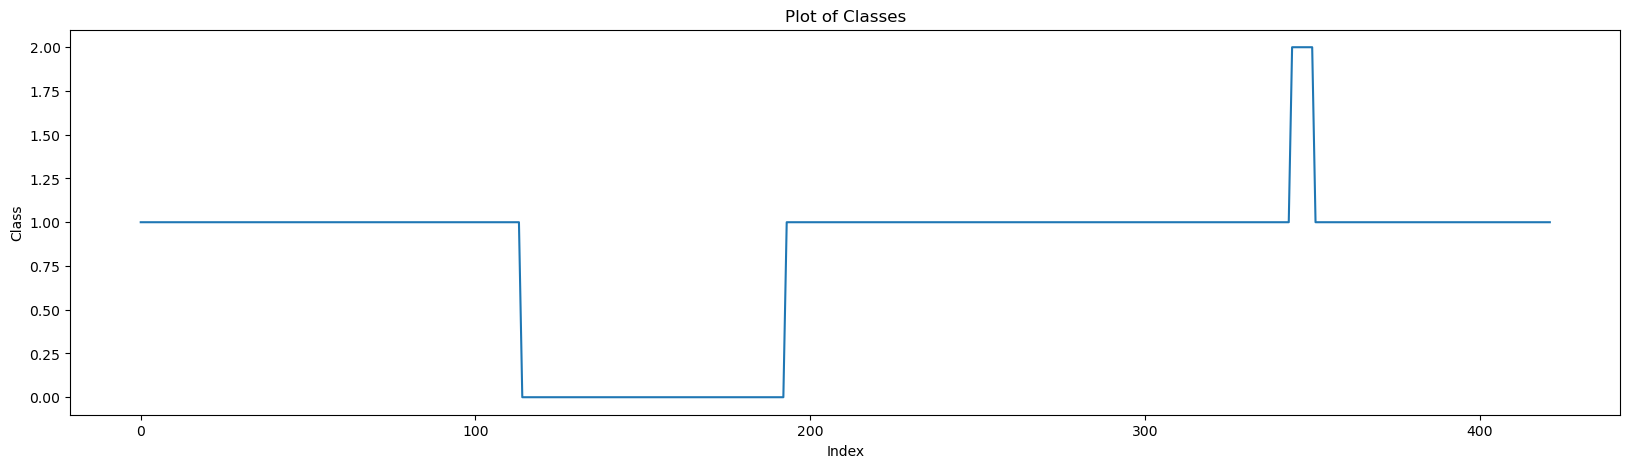

In [63]:

# Display classes value changes over time (last 500 ticks)
graph_ticks = 500
x = range(len(classes[-graph_ticks:]))

plt.figure(figsize=(20,5))
plt.plot(x, classes[-graph_ticks:], linestyle='-')

plt.xlabel('Index')
plt.ylabel('Class')
plt.title('Plot of Classes')

plt.show()

In [64]:

# Calculate the signals as input for the neural network as proportions
import preprocessing.proportions_calc as proportions

signals_calculator = proportions.ProportionsCalc(signal_avg)

proportions_avg = signals_calculator.calculate(close_prices)


In [65]:
print(f"Prices length: {len(close_prices)}")
print(f"Proportions length: {len(proportions_avg[-1])}")

print(f"Last 10 close: {close_prices[-10:]}")
print(f"Last 10 proportions(avg={signal_avg[0]}): {proportions_avg[0][-10:]}")

print(f"Proportions avgs: Length: {len(signal_avg)} Last: {signal_avg[-1]}")
# At the end of the data, when less ticks than necessary no possible to predict so "-1" 
print(f"Classes last non-negative-1: {classes[-TICKS_PREDICT-1:-TICKS_PREDICT+1]} len: {len(classes)}")
print(f"Proportions first non-negative-1(avg={signal_avg[-1]}): {proportions_avg[-1][signal_avg[-1]-2:signal_avg[-1]]} len: {len(proportions_avg[-1])}")
print(f"Proportions (avg={signal_avg[0]}) Min: {min(proportions_avg[0][signal_avg[0]-1:-TICKS_PREDICT-1])} Max: {max(proportions_avg[0][signal_avg[0]-1:-TICKS_PREDICT])}")
print(f"Proportions (avg={signal_avg[-1]}) Min: {min(proportions_avg[-1][signal_avg[-1]-1:-TICKS_PREDICT-1])} Max: {max(proportions_avg[-1][signal_avg[-1]-1:-TICKS_PREDICT])}")

Prices length: 5538
Proportions length: 5538
Last 10 close: [179.41, 179.64, 179.755, 179.795, 179.57, 179.535, 179.245, 179.525, 179.71, 179.25]
Last 10 proportions(avg=2): [0.0009754194303516309, 0.000640169227340146, 0.0003198798364405957, 0.00011123779860054482, -0.000626496630843728, -9.747403013679429e-05, -0.0008089486457117748, 0.0007798356774788442, 0.0005147181570272988, -0.0012831241283160026]
Proportions avgs: Length: 16 Last: 2584
Classes last non-nan: [1, nan] len: 5538
Proportions first non-nan(avg=2584): [nan, 0.049910358561487685] len: 5538
Proportions (avg=2) Min: -0.050165409554059105 Max: 0.05113530243602635
Proportions (avg=2584) Min: -0.4378489986351342 Max: 0.08356378413010114


In [66]:
# Removing the "-1" from the proportions
#   At the beging first signal_avg[-1] are "-1" (need previous values for first avg.)
#   At the end decided not predict if period to predict is shorter
targets = classes[signal_avg[-1]-1:-TICKS_PREDICT]
inputs = []
for proportion in proportions_avg:
    proportion_cut= proportion[signal_avg[-1]-1:-TICKS_PREDICT]
    print(proportion_cut[:2])
    inputs.append(proportion_cut)

print(f"First target: {targets[0]} and last target: {targets[-1]}")
print(f"Classes: {len(classes)} after cut to targets: {len(targets)}")
print(f"Inputs len: {len(inputs[len(signal_avg)-1])}")
print(f"Distinct targets: {list(set(targets))}")


[-0.002511375051707199, -0.00011821029611926006]
[-0.00422830204783744, -0.001832259589810174]
[-0.006271543658535639, -0.005102744449045494]
[-0.009671256081464399, -0.008021061134422273]
[-0.006875788829344481, -0.0076867002808265516]
[-0.0009088785901406069, -0.0013331494506503925]
[0.001825453930313883, 0.001370428187822093]
[0.006360717617586803, 0.005729617231478872]
[0.0307539702299974, 0.029775712565688076]
[0.04259174452476396, 0.04208929583877784]
[0.04424128576316073, 0.04383995408231889]
[0.046964685785141166, 0.046560171836586985]
[0.05514776184899424, 0.054819346568366914]
[0.0945377021370803, 0.09417557989665766]
[0.07047594224990028, 0.07026085923242398]
[0.049910358561487685, 0.04970193987487873]
First target: 1 and last target: 1
Classes: 5538 after cut to targets: 2877
Inputs len: 2877
Distinct targets: [0, 1, 2]


In [67]:
from collections import Counter

print("Test data: '-1' removed from begining and end")
lu.display_frequency_classes(targets, DOWN_PCTS_PREDICT, UP_PCTS_PREDICT)

targets_frequency = Counter(targets)
print("VALIDATE removing should be POSITIVE?")
count_remove_a= targets_frequency[INDEX_REMOVE_A] - targets_frequency[INDEX_KEEP] + targets_frequency[INDEX_KEEP] //2
count_remove_b= targets_frequency[INDEX_REMOVE_B] - targets_frequency[INDEX_KEEP] + targets_frequency[INDEX_KEEP] //2
print(f"Removing {INDEX_REMOVE_A}: {count_remove_a}")
print(f"Removing {INDEX_REMOVE_B}: {count_remove_b}")


Test data: 'nan' removed from begining and end
Total: 2877
 33.75%    971 times -3.0% change (0)
 52.45%   1509 times   0% change (1)
 13.80%    397 times 3.0% change (2)
VALIDATE removing should be POSITIVE?
Removing 1: 1023
Removing 2: -89


In [68]:
###################
##### SET PARAMETERS
###################
# DECISION SET: REMOVING?
indexes_remove_a= []
# 2024-03-01 Do not remove anything
# if count_remove_a > 0:
#     indexes_remove_a = get_indexes_value(targets, index_remove_a, count_remove_a)

# DECISION SET: REMOVING?
indexes_remove_b= []
# 2024-03-01 Do not remove anything
# if count_remove_b > 0:
#     indexes_remove_b = get_indexes_value(targets, index_remove_b, count_remove_b)

indexes_remove= indexes_remove_a + indexes_remove_b
targets_clean= lu.remove_indexes(targets, indexes_remove)

lu.display_frequency_classes(targets_clean, DOWN_PCTS_PREDICT, UP_PCTS_PREDICT)
print(f"Targets len: {len(targets)} Targets clean: {len(targets_clean)} Difference: {len(targets)-len(targets_clean)}")

inputs_clean = [lu.remove_indexes(input, indexes_remove) for input in inputs]    
print(f"targets_clean positions(Keep={INDEX_KEEP})(First:{targets_clean.index(INDEX_KEEP)},Last:-{targets_clean[::-1].index(INDEX_KEEP)})")


Total: 2877
 33.75%    971 times -3.0% change (0)
 52.45%   1509 times   0% change (1)
 13.80%    397 times 3.0% change (2)
Targets len: 2877 Targets clean: 2877 Difference: 0
targets_clean positions(Keep=0)(First:189,Last:-229)


In [69]:
# Sets 'index_keep' as target = 1 and rest of indexes to target=0
targets_binary= lu.convert_binary(targets_clean, INDEX_KEEP)
print(f"targets_binary First {targets_binary.index(True)} and Last(counting from end) {targets_binary[::-1].index(True)} position with True")
print(f"targets_binary len: {len(targets_binary)} Input clean[0]: {len(inputs_clean[0])} Input clean[-1]: {len(inputs_clean[-1])}")

targets_binary First 189 and Last(counting from end) 229 position with True
targets_binary len: 2877 Input clean[0]: 2877 Input clean[-1]: 2877


In [70]:
import torch

inputs_tensor = torch.Tensor(inputs_clean)
print(f"inputs_tensor: {inputs_tensor.size()}")
inputs_tensor = inputs_tensor.T
print(f"inputs_tensor: {inputs_tensor.size()}")
targets_tensor = torch.Tensor(targets_binary)
print(f"inputs_clean len0 x len1: {len(inputs_clean)} x {len(inputs_clean[0])} -> inputs_tensor.shape: {inputs_tensor.shape}")
print(f"targets_binary.shape: {len(targets_binary)} -> targets_tensor.shape: {targets_tensor.shape}")
print(f"inputs_tensor: {inputs_tensor}")
print(f"targets_tensor: {targets_tensor}")

inputs_tensor: torch.Size([16, 2877])
inputs_tensor: torch.Size([2877, 16])
inputs_clean len0 x len1: 16 x 2877 -> inputs_tensor.shape: torch.Size([2877, 16])
targets_binary.shape: 2877 -> targets_tensor.shape: torch.Size([2877])
inputs_tensor: tensor([[-0.0025, -0.0042, -0.0063,  ...,  0.0945,  0.0705,  0.0499],
        [-0.0001, -0.0018, -0.0051,  ...,  0.0942,  0.0703,  0.0497],
        [ 0.0014,  0.0018, -0.0004,  ...,  0.0966,  0.0729,  0.0525],
        ...,
        [-0.0015, -0.0030, -0.0028,  ...,  0.0775,  0.0577, -0.0030],
        [ 0.0022,  0.0019,  0.0004,  ...,  0.0816,  0.0619,  0.0016],
        [ 0.0029,  0.0053,  0.0055,  ...,  0.0868,  0.0674,  0.0075]])
targets_tensor: tensor([0., 0., 0.,  ..., 0., 0., 0.])


In [71]:

inputs_tensor_test, targets_tensor_test= inputs_tensor, targets_tensor

print("Test dataset frequencies:")
lu.display_frequency_values(targets_tensor_test.tolist())



Test dataset frequencies:
Total: 2877
 66.25%   1906 times (0.0)
 33.75%    971 times (1.0)


In [72]:
from typing import Tuple
import torch
from torch.utils.data import Dataset

class StockDataset(Dataset):
    def __init__(
        self,
        inputs,
        targets):
        
        self.inputs= inputs
        self.targets= targets

    def __len__(self) -> int:
        return len(self.targets)

    def __getitem__(self, index: int) -> Tuple[torch.Tensor, int]:
        return self.inputs[index], self.targets[index]


In [73]:
from torch.utils.data import DataLoader

# TODO: When executing only using 33-38% GPU - Try different BATCH_SIZE see if parallelism increases? Learning decreases because less batches?
BATCH_SIZE= 32

test_dataset= StockDataset(
  inputs_tensor_test,
  targets_tensor_test
)

print(f"First input vector:\n{test_dataset[0]}")

test_dataloader= DataLoader(
  dataset=test_dataset,
  batch_size=BATCH_SIZE,
  shuffle=False
)

test_input0, test_target0= next(iter(test_dataloader))
print(f"Dataloader batch={BATCH_SIZE}\nInput:\n{test_input0}\nTargets:\n{test_target0}")


First input vector:
(tensor([-0.0025, -0.0042, -0.0063, -0.0097, -0.0069, -0.0009,  0.0018,  0.0064,
         0.0308,  0.0426,  0.0442,  0.0470,  0.0551,  0.0945,  0.0705,  0.0499]), tensor(0.))
Dataloader batch=32
Input:
tensor([[-2.5114e-03, -4.2283e-03, -6.2715e-03, -9.6713e-03, -6.8758e-03,
         -9.0888e-04,  1.8255e-03,  6.3607e-03,  3.0754e-02,  4.2592e-02,
          4.4241e-02,  4.6965e-02,  5.5148e-02,  9.4538e-02,  7.0476e-02,
          4.9910e-02],
        [-1.1821e-04, -1.8323e-03, -5.1027e-03, -8.0211e-03, -7.6867e-03,
         -1.3331e-03,  1.3704e-03,  5.7296e-03,  2.9776e-02,  4.2089e-02,
          4.3840e-02,  4.6560e-02,  5.4819e-02,  9.4176e-02,  7.0261e-02,
          4.9702e-02],
        [ 1.4439e-03,  1.8466e-03, -3.6146e-04, -3.2561e-03, -5.3268e-03,
          9.7850e-04,  4.0515e-03,  8.2376e-03,  3.1710e-02,  4.4562e-02,
          4.6377e-02,  4.9131e-02,  5.7438e-02,  9.6638e-02,  7.2942e-02,
          5.2459e-02],
        [ 3.9287e-05,  1.0149e-03,  6.9930e

In [81]:
# EXECUTE FROM THIS STEP To CREATE A NETWORK WITH RANDOM WEIGHTS

import torch
from torch import nn

class StockModelBinaryV0(nn.Module):
  def __init__(self, input_features, hidden_units):
    """Initializes multi-class classification model"""
    super().__init__()
    self.linear_layer_stack = nn.Sequential(
      nn.Linear(in_features=input_features, out_features=hidden_units*16),
      nn.LeakyReLU(negative_slope=0.1),
      nn.Linear(in_features=hidden_units*16, out_features=hidden_units*8),
      nn.LeakyReLU(negative_slope=0.1),
      nn.Linear(in_features=hidden_units*8, out_features=hidden_units*4),
      nn.LeakyReLU(negative_slope=0.1),
      nn.Linear(in_features=hidden_units*4, out_features=hidden_units),
      nn.LeakyReLU(negative_slope=0.1),
      nn.Linear(in_features=hidden_units, out_features=1)
    )

  def forward(self, x):
    # print("forward x: ",", ".join([str(num) for num in x.tolist()]))
    # Layers are defined inside the Sequencial NN and will be applied here.
    return self.linear_layer_stack(x)

# Create an instance of the model
model_0 = StockModelBinaryV0(
  input_features=len(signal_avg),
  hidden_units=HIDDEN_UNITS).to(device)


In [82]:
# Loads model from file
from pathlib import Path

# Create directory, if it doesn't exist, to store models
MODEL_PATH= Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

model_0.load_state_dict(torch.load(f=MODEL_SAVE_PATH))
model_0.to(device)

print(f"Test model loaded: {MODEL_NAME}")

Test model loaded: 2024-06-01-0656-TSLA-predictDOWN-dates20190102-20231229-days3-down300-up300-in16-hid12-pos_weight13979-prec9737pct-fp22tp815-high_prec.pth


Test threshold: 0.9598954
Test confusion matrix:
tensor([[1637,  269],
        [ 764,  207]])
Test Accuracy: 64.09%
Test Precision: 43.49%
Test false_positives: 269 true_positives: 207


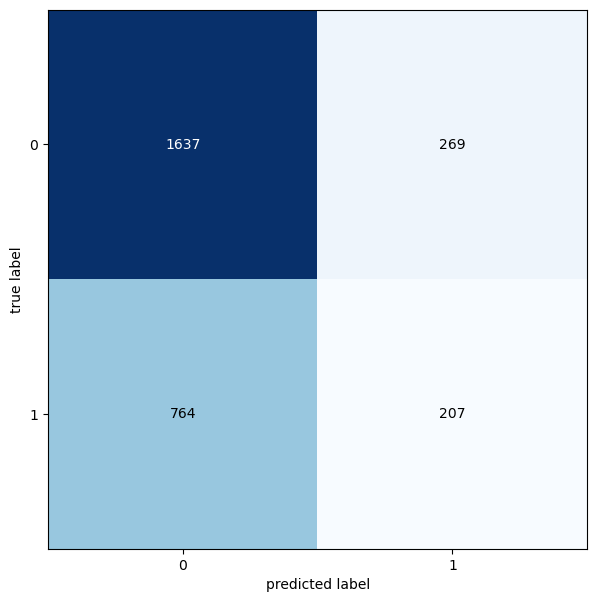

In [89]:
from torchmetrics import ConfusionMatrix, Accuracy, Precision
from mlxtend.plotting import plot_confusion_matrix

model_0.eval()
test_precision= 0
with torch.inference_mode():
    X= inputs_tensor_test.to(device)
    y= targets_tensor_test.to(device)

    # Predict for test data
    test_logits= model_0(X).view(-1)
    sigmoid_output = torch.sigmoid(test_logits)
    test_pred = (sigmoid_output > TEST_THRESHOLD).float()    

confmat= ConfusionMatrix(task='binary')

# test_data.targets are the values we want to predict in the test dataloader
confmat_tensor= confmat(
  preds= test_pred.cpu(),
  target= targets_tensor_test.cpu())

# Plot confusion matrix
fig, ax= plot_confusion_matrix(
  conf_mat= confmat_tensor.numpy(),
  figsize= (10, 7)
)

accuracy_fn= Accuracy(task='binary').to(device)
test_accuracy = accuracy_fn(test_pred, y)
print(f"Test threshold: {TEST_THRESHOLD}")
print(f"Test confusion matrix:\n{confmat_tensor}")

precision_fn= Precision(task='binary').to(device)
test_precision = precision_fn(test_pred, y)
print(f"Test Accuracy: {test_accuracy*100:.2f}%")
print(f"Test Precision: {test_precision*100:.2f}%")
false_positives = confmat_tensor[0, 1].item()
true_positives = confmat_tensor[1, 1].item()
print(f"Test false_positives: {false_positives} true_positives: {true_positives}")

In [90]:
# Example of threshold adjustment after model training
from sklearn.metrics import precision_recall_curve
import numpy as np

model_0.eval()
with torch.no_grad():
    X= inputs_tensor_test.to(device)
    y= targets_tensor_test.to(device)

    logits = model_0(X)
    probs = torch.sigmoid(logits).cpu().numpy()
    y_cpu = y.cpu().numpy()
    
precision, recall, thresholds = precision_recall_curve(y_cpu, probs)

# Find the threshold that gives the highest precision
optimal_idx = np.argmax(precision[:-1])
optimal_threshold = thresholds[optimal_idx]
print("Optimal threshold: ", optimal_threshold)

Optimal threshold:  0.9598954


#### Summary

In [91]:
print("======TEST:")
print(f"Trained model: {MODEL_NAME}")
print(f"Ticker: {TICKER}")

print(f"Data start: {df['date'][0]} end: {df['date'].iloc[-1]}")
print(f"Data Interval: {DATA_INTERVAL_MINUTES} - After Hours: {DATA_AFTER_HOURS}")

print(f"Signal Averages: {signal_avg}")
print(f"Predict {'UP' if PREDICT_UP else 'DOWN'} - days: {DAYS_PREDICT} Down pcts: {DOWN_PCTS_PREDICT} Up pcts: {UP_PCTS_PREDICT}")
print("Targets Frequencies:")
lu.display_frequency_classes(targets_clean, DOWN_PCTS_PREDICT, UP_PCTS_PREDICT)

print("Test dataset frequencies:")
lu.display_frequency_values(targets_tensor_test.tolist())

print("--Inference")
print(f"Network hidden units: {HIDDEN_UNITS}")
print(f"== Test threshold: {TEST_THRESHOLD}")

print("--Inference Results")
print(f"Test confusion matrix:\n{confmat_tensor}")
print(f"Val accuracy: {val_accuracy*100:.2f}%")
print(f"Val precision: {val_precision*100:.2f}%")
print(f"Val false_positives: {false_positives} true_positives: {true_positives}")
print(f"Val Precision manual: {precision_m*100:.2f}%")
print(f"Val Recall manual: {recall_m*100:.2f}%")
print(f"Val F1-score manual: {2 * precision_m * recall_m / (precision_m + recall_m):.4f}")



======TEST:
Ticker: TSLA
Data start: 2023-08-01 09:30:00-04:00 end: 2024-05-24 15:45:00-04:00
Data Interval: 15 - After Hours: False
Signal Averages: [2, 3, 5, 8, 13, 21, 34, 55, 89, 144, 233, 377, 610, 987, 1597, 2584]
Predict DOWN - days: 3 Down pcts: [3.0] Up pcts: [3.0]
Targets Frequencies:
Total: 2877
 33.75%    971 times -3.0% change (0)
 52.45%   1509 times   0% change (1)
 13.80%    397 times 3.0% change (2)
Test dataset frequencies:
Total: 2877
 66.25%   1906 times (0.0)
 33.75%    971 times (1.0)
--Inference
Network hidden units: 12
== Test threshold: 0.9598954
--Inference Results
Trained model: 2024-06-01-0656-TSLA-predictDOWN-dates20190102-20231229-days3-down300-up300-in16-hid12-pos_weight13979-prec9737pct-fp22tp815-high_prec.pth
Test confusion matrix:
tensor([[1637,  269],
        [ 764,  207]])
Test accuracy: 64.09%
Test precision: 43.49%
Test false_positives: 269 true_positives: 207
Test optimal threshold precision_recall_curve:  0.9598954
